In [1]:
# installing requirements from txt file
#pip install -r requirements.txt

In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import yfinance as yf
from datetime import datetime
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, LayerNormalization, GlobalAveragePooling1D, Embedding
import seaborn as sns
import matplotlib.pyplot as plt

# **Step 1: Data retrieval and indicators calculation**

The idea is to consider a portfolio made only of SPY ETF, as it has been seen that holding an ETF which replicates the Standard and Poor 500 can be one of the best investments you can make.

In [3]:
# downloading monthly prices of the SPY ETF, as VIX data will be monthly and therefore we keep returns as monthly
spy_prices_hist = yf.download('SPY', start = '2005-07-01', end = '2024-12-31', interval = '1mo', multi_level_index = False, auto_adjust = False) # starting since when we have availability for the VIX futures historical term structure
#if isinstance(spy_prices.columns, pd.MultiIndex):
    #spy_prices = spy_prices.xs(key="SPY", axis=1, level=1)
spy_prices_hist = spy_prices_hist['Adj Close'] # taking only adjusted close prices
spy_prices_hist

[*********************100%***********************]  1 of 1 completed


Date
2005-07-01     85.602921
2005-08-01     84.800415
2005-09-01     85.118637
2005-10-01     83.459282
2005-11-01     87.127556
                 ...    
2024-08-01    560.071289
2024-09-01    570.086792
2024-10-01    566.732605
2024-11-01    600.528809
2024-12-01    584.114075
Name: Adj Close, Length: 234, dtype: float64

In [4]:
spy_rets_hist = spy_prices_hist.pct_change().dropna() # computing returns and dropping NAs (most importantly, dropping the first observation)
spy_rets_hist.rename('SPY returns', inplace = True) # renaming the column as now we have returns and not prices
spy_rets_hist

Date
2005-08-01   -0.009375
2005-09-01    0.003753
2005-10-01   -0.019495
2005-11-01    0.043953
2005-12-01   -0.007177
                ...   
2024-08-01    0.023366
2024-09-01    0.017883
2024-10-01   -0.005884
2024-11-01    0.059633
2024-12-01   -0.027334
Name: SPY returns, Length: 233, dtype: float64

Next, we upload VIX future (UX1 index) term structure data downloaded from Bloomberg as of January 2025, for the next months of 2025. The idea is to use this data for forecasting SPY returns for the year 2025 and, more in general, to predict scenarios of what will happen in the upcoming months and how our strategy works:

In [5]:
vix_data_ahead = pd.read_excel('VIX_term_structure_20250117.xlsx', header = 0) # uploading VIX futures ahead term structure data
vix_data_ahead = vix_data_ahead.drop(vix_data_ahead.index[0]) # removing first unnecessary row

for i in range(2, len(vix_data_ahead) + 1): # turning the Period column into datetime, needed for further analyses
    vix_data_ahead['Period'][i] = datetime.strptime(vix_data_ahead['Period'][i], '%m/%Y')
    
vix_data_ahead

C:\Users\aless\AppData\Local\Temp\ipykernel_3740\222383742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data_ahead['Period'][i] = datetime.strptime(vix_data_ahead['Period'][i], '%m/%Y')
C:\Users\aless\AppData\Local\Temp\ipykernel_3740\222383742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data_ahead['Period'][i] = datetime.strptime(vix_data_ahead['Period'][i], '%m/%Y')
C:\Users\aless\AppData\Local\Temp\ipykernel_3740\222383742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,Tenor,Ticker,Period,Last Price,Days to expiration
1,Spot,VIX Index,Spot,15.9700,0.0
2,1M,UXF5 Index,2025-01-01 00:00:00,16.1792,30.0
3,1M,UXG5 Index,2025-02-01 00:00:00,17.2382,60.0
4,2M,UXH5 Index,2025-03-01 00:00:00,17.8351,90.0
5,3M,UXJ5 Index,2025-04-01 00:00:00,18.1962,120.0
6,4M,UXK5 Index,2025-05-01 00:00:00,18.4005,150.0
7,5M,UXM5 Index,2025-06-01 00:00:00,18.5484,180.0
8,6M,UXN5 Index,2025-07-01 00:00:00,18.8250,210.0
9,7M,UXQ5 Index,2025-08-01 00:00:00,18.8000,240.0
10,8M,UXU5 Index,2025-09-01 00:00:00,19.1000,270.0


In the table above, the Tenor column represents the maturity of each row of the term structure, ahead in time. The Ticker column gives information on which is the Bloomberg ticker used for the specific row, then a datetime version of the maturity follows in the Period column, together with price and days to expiration. We are basing our research as if we are at the beginning of January 2025 and we are going to be stuck there in time, as doing this in real time would be too computationally expensive.

In addition to that, we also upload the historical VIX futures term structure, as we will use this for training our model, together with historical past returns of the SPY. The process of uploading and data manipulation is exactly the same as for the ahead term structure data:

In [6]:
vix_data_hist = pd.read_excel('hist_vix_term_structure.xlsx', header = 0) # uploading VIX futures ahead term structure data
vix_data_hist = vix_data_hist.drop(vix_data_hist.index[0]) # removing first unnecessary row

for i in range(1, len(vix_data_hist) + 1): # turning the Period column into datetime, needed for further analyses
    vix_data_hist['Period'][i] = datetime.strptime(vix_data_hist['Period'][i], '%m/%Y')
    
vix_data_hist = vix_data_hist.sort_values(by = 'Period') # in the historical data, futures prices are not ordered properly in ascending or descending order
vix_data_hist

C:\Users\aless\AppData\Local\Temp\ipykernel_3740\1655688991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data_hist['Period'][i] = datetime.strptime(vix_data_hist['Period'][i], '%m/%Y')
C:\Users\aless\AppData\Local\Temp\ipykernel_3740\1655688991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data_hist['Period'][i] = datetime.strptime(vix_data_hist['Period'][i], '%m/%Y')
C:\Users\aless\AppData\Local\Temp\ipykernel_3740\1655688991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,Tenor,Ticker,Period,Last Price,Days past
166,5Y,UXG05 Index,2005-02-01 00:00:00,11.4800,7170.0
167,61M,UXH05 Index,2005-03-01 00:00:00,12.2200,7140.0
168,63M,UXK05 Index,2005-05-01 00:00:00,13.1600,7080.0
169,66M,UXQ05 Index,2005-08-01 00:00:00,14.4300,6990.0
162,6Y,UXG06 Index,2006-02-01 00:00:00,12.8700,6810.0
...,...,...,...,...,...
5,292M,UXM4 Index,2024-06-01 00:00:00,16.6821,210.0
6,293M,UXN4 Index,2024-07-01 00:00:00,17.1011,180.0
7,294M,UXQ4 Index,2024-08-01 00:00:00,17.3603,150.0
8,295M,UXU4 Index,2024-09-01 00:00:00,17.6000,120.0


Now we are going to define three functions which will be used to compute the indicators that are going to be part of the innovative strategy. The rolling volatility, rolling correlation and rate of change indicators will be used to double check that the switches between momentum and mean-reversion strategies make sense or to question them.

In [7]:
## creating functions for the three indicators which will compose the innovative part of our approach

def rolling_std(series, time_interval): # defining a function for volatility, which we consider as rolling standard deviation
    return series.rolling(window = time_interval).std()

def rolling_correlation(series1, series2, time_interval): # defining a function for the rolling correlation
    return series1.rolling(window = time_interval).corr(series2)

def ROC(series): # defining a function for the rate of change, that will be primarly used for the VIX slope
    return series.pct_change()

Furthermore, we are going to define a function that will create two new term structures, one for the historical one and the other for the ahead in time one, with newly calculated prices.
The prices will be calculated via linear interpolation with a targeted maturity, taken as the midpoint between two maturities, so that the new term structure is characterized by constant maturity.

In [8]:
def constant_mat_term_structure(vix_term_structure):
    """
    This function computes the linear interpolation of VIX futures prices 
    for generating a constant maturity term structure.
    
    It takes the VIX dataframe, be it either the historical one or the future one, as input,
    and will return the interpolated prices of the VIX futures.
    """
    
    constant_maturity_prices = [] # allocating memory for the prices computed with constant maturity approach
    for i in range(1, len(vix_term_structure)): # looping over all observations of the dataframe fed to the function
        maturity1 = vix_term_structure.loc[i - 1, "Days to expiration"] # first maturity
        maturity2 = vix_term_structure.loc[i, "Days to expiration"] # second maturity
        price1 = vix_term_structure.loc[i - 1, "Last Price"] # first price
        price2 = vix_term_structure.loc[i, "Last Price"] # second price
        
        target_maturity = (maturity1 + maturity2) / 2 # the target maturity is identified as the middle point between maturity 1 and 2
        
        # formula decided to be used for price interpolation
        interpolated_price = price1 * (maturity2 - target_maturity) / (maturity2 - maturity1) + price2 * (target_maturity - maturity1) / (maturity2 - maturity1)
        constant_maturity_prices.append(interpolated_price) # appending each result of the loop in the initially created variable
    
    constant_maturity_prices.insert(0, None) # adding NaN for the first row since it doesn't have a previous contract
    vix_term_structure["Constant Maturity Price"] = constant_maturity_prices # adding the newly computed prices to the original table
    return vix_term_structure

Running the function for both historical and 2025 VIX futures term structures:

In [9]:
vix_data_ahead = vix_data_ahead.reset_index(drop = True) # resetting the index of the ahead term structure for data manipulation
constant_maturity_ahead = constant_mat_term_structure(vix_data_ahead) # computing constant maturity ahead term structure

vix_data_hist = vix_data_hist.reset_index(drop = True) # resetting the index of the ahead term structure for data manipulation
vix_data_hist.rename(columns = {'Days past': 'Days to expiration'}, inplace = True) # column renaming for data manipulation (the function admits 'Days to expiration', we could have changed the function but it would require more than one line as here)
constant_maturity_hist = constant_mat_term_structure(vix_data_hist) # computing constant maturity historical term structure
vix_data_hist.rename(columns = {'Days to expiration': 'Days past'}, inplace = True) # column renaming for data manipulation (the function admits 'Days to expiration', we could have changed the function but it would require more than one line as here)

In [10]:
print("Constant Maturity Term Structure ahead:") # printing the new ahead term structure, made of prices at constant maturity
constant_maturity_ahead[['Period', 'Constant Maturity Price']]

Constant Maturity Term Structure ahead:


,Period,Constant Maturity Price
0,Spot,NaN
1,2025-01-01 00:00:00,16.07460
2,2025-02-01 00:00:00,16.70870
3,2025-03-01 00:00:00,17.53665
4,2025-04-01 00:00:00,18.01565
5,2025-05-01 00:00:00,18.29835
6,2025-06-01 00:00:00,18.47445
7,2025-07-01 00:00:00,18.68670
8,2025-08-01 00:00:00,18.81250
9,2025-09-01 00:00:00,18.95000


In [11]:
print("Constant Maturity Term Structure historical:") # printing the new historical term structure, made of prices at constant maturity
constant_maturity_hist[['Period', 'Constant Maturity Price']]

Constant Maturity Term Structure historical:


,Period,Constant Maturity Price
0,2005-02-01 00:00:00,NaN
1,2005-03-01 00:00:00,11.85000
2,2005-05-01 00:00:00,12.69000
3,2005-08-01 00:00:00,13.79500
4,2006-02-01 00:00:00,13.65000
...,...,...
164,2024-06-01 00:00:00,16.51625
165,2024-07-01 00:00:00,16.89160
166,2024-08-01 00:00:00,17.23070
167,2024-09-01 00:00:00,17.48015


If one compares the two term structures just obtained with the previous versions originally uploaded here, not at constant maturity, then it can be observed that the interpolated prices and the original prices are not so distant from each other.

Calculating the slope of the constant maturity VIX futures term structure in a normalized way, meaning with the difference in prices at the numerator and the difference in days at the denominator:

In [12]:
# computing the slope of the ahead term structure
constant_maturity_ahead['vix_slope'] = constant_maturity_ahead["Constant Maturity Price"].diff() / constant_maturity_ahead["Days to expiration"].diff()
constant_maturity_ahead['vix_slope']

0         NaN
1         NaN
2    0.021137
3    0.027598
4    0.015967
5    0.009423
6    0.005870
7    0.007075
8    0.004193
9    0.004583
Name: vix_slope, dtype: float64

Applying the same to the historical constant maturity term structure (to evaluate if a negative sign is needed in front of this):

In [13]:
# computing the slope of the historical term structure
constant_maturity_hist["vix_slope"] = constant_maturity_hist["Constant Maturity Price"].diff() / constant_maturity_hist["Days past"].diff() # maybe a negative sign in front of it?
constant_maturity_hist["vix_slope"]

0           NaN
1           NaN
2     -0.014000
3     -0.012278
4      0.000806
         ...   
164   -0.013038
165   -0.012512
166   -0.011303
167   -0.008315
168   -0.052328
Name: vix_slope, Length: 169, dtype: float64

An initial calculation of the three indicators follows. In order to compute the rolling correlation between the slope of the VIX futures term structure, we are going to combine that data with the SPY returns in a unique dataframe for ease of computation.

In [14]:
# now the idea is to merge the historical VIX dataframe with returns from SPY, so that we have aligned data and we can compute correlation
constant_maturity_hist = constant_maturity_hist.set_index('Period', drop = True) # setting the dates as index
correlation_dataset = constant_maturity_hist.join(spy_rets_hist, how = 'left') # adding the returns from SPY to the historical VIX dataframe
correlation_dataset = correlation_dataset.drop(['Tenor', 'Ticker', 'Last Price', 'Days past', 'Constant Maturity Price'], axis = 1) # dropping unnecessary columns for correlation analysis

correlation_dataset

,vix_slope,SPY returns
Period,,
2005-02-01,NaN,NaN
2005-03-01,NaN,NaN
2005-05-01,-0.014000,NaN
2005-08-01,-0.012278,-0.009375
2006-02-01,0.000806,0.005725
...,...,...
2024-06-01,-0.013038,0.031951
2024-07-01,-0.012512,0.015374
2024-08-01,-0.011303,0.023366


Using the previously defined three functions, we are computing the innovative indicators that we are going to use as a double check after the momentum transformer:

In [15]:
vol_indicator = rolling_std(spy_rets_hist, time_interval = 5).dropna() # calculating volatility indicator on the returns of SPY
correlation_indicator = rolling_correlation(correlation_dataset['vix_slope'], correlation_dataset['SPY returns'], time_interval = 5).dropna() # computing correlation indicator between SPY returns and historical VIX slope
roc_indicator = ROC(correlation_dataset['vix_slope']).dropna() # calculating rate of change of the historical VIX futures constant maturity term structure slope
roc_indicator.replace([np.inf, -np.inf], np.nan, inplace = True) # replacing infinite values with nan, as there are a couple of zeros in the slope columns which generate inf
roc_indicator.dropna(inplace = True) # dropping again rows with nan values

In [16]:
print("Historical rolling volatility indicator:")
print(vol_indicator)

Historical rolling volatility indicator:
Date
2005-12-01    0.024689
2006-01-01    0.026147
2006-02-01    0.026043
2006-03-01    0.020083
2006-04-01    0.013524
                ...   
2024-08-01    0.032965
2024-09-01    0.014218
2024-10-01    0.014054
2024-11-01    0.023751
2024-12-01    0.032741
Name: SPY returns, Length: 229, dtype: float64


In [17]:
print("Historical rolling correlation indicator:")
print(correlation_indicator)

Historical rolling correlation indicator:
Period
2006-08-01    0.411582
2007-02-01    0.156484
2007-03-01    0.276882
2007-04-01   -0.271602
2007-05-01   -0.628517
                ...   
2024-06-01    0.292606
2024-07-01    0.264486
2024-08-01    0.620179
2024-09-01   -0.911278
2024-10-01    0.866637
Length: 162, dtype: float64


In [18]:
print("Historical VIX slope rate of change indicator:")
print(roc_indicator)

Historical VIX slope rate of change indicator:
Period
2005-08-01    -0.123016
2006-02-01    -1.065611
2006-03-01    25.068966
2006-05-01    -1.690476
2006-08-01    -0.022989
                ...    
2024-06-01    -0.420519
2024-07-01    -0.040394
2024-08-01    -0.096577
2024-09-01    -0.264376
2024-10-01     5.293245
Name: vix_slope, Length: 163, dtype: float64


# **Step 2: Training the Momentum Transformer model (model development)**

## **2.1: Double LSTM approach**

In order to train the momentum transformer model, we take the correlation_dataset dataframe created above, because it contains everything we need for the model training: namely, our x variable is the slope of the historical VIX futures term structure data, while our y variable is represented by the SPY returns.

In [19]:
correlation_dataset = correlation_dataset.dropna() # dropping the first NAs due to rolling window
spy_rets_training = correlation_dataset['SPY returns'] # identifying the historical SPY returns for training
vix_slope_training = correlation_dataset['vix_slope'] # identifying the historical VIX slope for training

Computing the three indicators for the training part:

In [20]:
vol_indicator_training = rolling_std(spy_rets_training, time_interval = 5).dropna() # computing volatility indicator for the training part
correlation_indicator_training = rolling_correlation(spy_rets_training, vix_slope_training, time_interval = 5).dropna() # computing correlation indicator for the training part
roc_indicator_training = ROC(vix_slope_training).dropna() # computing roc indicator for the training part
roc_indicator_training.replace([np.inf, -np.inf], np.nan, inplace = True) # replacing infinite values with nan, as there are a couple of zeros in the slope columns which generate inf
roc_indicator_training.dropna(inplace = True) # dropping again rows with nan values

Momentum transformer has become quite famous in this area of research because RNNs and LSTM approaches generate vanishing or exploding gradients. Therefore, we are first exploring what happens with LSTM, before moving on to the momentum transformer approach.

Combining the two variables in a proper dataframe, which is called also differently, so that it is clear that now we are starting to group the data.

In [21]:
## first, we are going to check results with a double LSTM, as normally momentum transformer replaces LSTM because of vanishing gradients
doubleLSTM_train_data = pd.DataFrame({ # combining historical vix slope and SPY returns data for training
    'Historical VIX futures slope': vix_slope_training,
    'Historical SPY Returns': spy_rets_training
}).dropna()

doubleLSTM_train_data

,Historical VIX futures slope,Historical SPY Returns
Period,,
2005-08-01,-0.012278,-0.009375
2006-02-01,0.000806,0.005725
2006-03-01,0.021000,0.012478
2006-05-01,-0.014500,-0.030121
2006-08-01,-0.014167,0.021822
...,...,...
2024-06-01,-0.013038,0.031951
2024-07-01,-0.012512,0.015374
2024-08-01,-0.011303,0.023366


Moving on, we are going to use StandardScaler to standardize the two variables that are going to be part of the model. In addition to this, we are also feeding to the model the vix slope variable in sequence: instead of providing the data as it is, we are providing sequences of the time series data, so that the model tries to understand the trends in the data over the specified length of the sequence. The idea is that, this way, the model will try to learn the data not taking each data point individually but rather trying to understand the temporal dependencies.
In our case, if the length of the sequence is equal to 5, it means the model is learning with sequences of 5-months data. Given this, the length of the sequence can be considered as a hyperparameter and we are going to explore also other possible options.

In [22]:
scaler_doubleLSTM = StandardScaler() # activating the scaler for standardizing the two variables
scaled_features_doubleLSTM = scaler_doubleLSTM.fit_transform(doubleLSTM_train_data) # standardizing

X_doubleLSTM, y_doubleLSTM = [], [] # pre-allocating memory for appending standardized values
sequence_length = 5 # instead of considering single data points, deciding for the length of a sequence of consecutive observations to fed the model with, in order to try to capture temporal dependencies

for i in range(sequence_length, len(scaled_features_doubleLSTM)): # appending
    X_doubleLSTM.append(scaled_features_doubleLSTM[i-sequence_length:i]) 
    y_doubleLSTM.append(spy_rets_training.iloc[i])

X_doubleLSTM = np.array(X_doubleLSTM) # turning the list into a numpy array
y_doubleLSTM = np.array(y_doubleLSTM) # turning the list into a numpy array

Splitting the two variables into a training and a testing part, for now considering an 80/20 split.

In [23]:
X_train_doubleLSTM, X_test_doubleLSTM, y_train_doubleLSTM, y_test_doubleLSTM = train_test_split(
    X_doubleLSTM, y_doubleLSTM, test_size = 0.2, random_state = 42
) # training-testing dataframes split, for now going with 80/20

Once the dataframes are prepared, it's time to define the approach we are going to use, and to actually run it to fit it on the training part of the model. We decided to opt for a sequential object with two LSTM: the first one with 64 hidden neurons to initially learn from the data and then a second LSTM, with 32 hidden neurons, to redefine the knowledge in a less complex way. 
Sigmoid activation function is used (we are exploring the possibility to change it to classification), Adam is the chosen optimizer and the mean squared error was selected as a loss measure.

In [24]:
doubleLSTM_model = Sequential([ # grouping layers into a model with Sequential, so that we have one output for each input in a layer
    LSTM(64, input_shape = (X_doubleLSTM.shape[1], X_doubleLSTM.shape[2]), return_sequences = True), # first Long-Short Term Memory approach
    Dropout(0.2), # first dropout rate
    LSTM(32, return_sequences = False), # second Long-Short Term Memory approach
    Dropout(0.2), # second dropout rate
    Dense(1, activation = 'sigmoid') # the output is a single value, try to see what happens if you change sigmoid with classification
])

doubleLSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error') # compiling with adam optimizer and mean-squared error loss
res = doubleLSTM_model.fit(X_train_doubleLSTM, y_train_doubleLSTM, # fitting the model on the testing part of the dataframes
                            epochs = 20, batch_size = 16, 
                            validation_data = (X_test_doubleLSTM, y_test_doubleLSTM)) # validation part (IS THIS REALLY NEEDED HERE?)

Epoch 1/20


C:\Users\aless\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - loss: 0.2349 - val_loss: 0.2228
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2144 - val_loss: 0.1903
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1779 - val_loss: 0.1356
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1180 - val_loss: 0.0587
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0424 - val_loss: 0.0094
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0078 - val_loss: 0.0025
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 13/20

Extracting forecasts and calculating the mean squared error between them and the actually testing part of the SPY returns:

In [25]:
forecasts_doubleLSTM = doubleLSTM_model.predict(X_test_doubleLSTM) # we can eventually check the forecasts on the testing part of the x variables
rmse_doubleLSTM = np.sqrt(mean_squared_error(y_test_doubleLSTM, forecasts_doubleLSTM)) # calculating root mean squared error as error measure between testing part of returns and forecasts
print("Double LSTM RMSE:", rmse_doubleLSTM)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 670ms/step
Double LSTM RMSE: 0.04813045366232955


The MSE value obtained is around 0.048, which is a small enough value to state that the forecasts of the SPY returns seem to be accurate.

However, we can't simply stop here, reason why we are not proceeding with this approach. A commonly recognized pitfall of LSTM approach is the fact that often presents vanishing or exploding gradients, meaning gradients which tend to zero or very close to zero, or too high maximum gradients. That is why we also implemented a piece of code to check the gradient norm evolution after each epoch of the model is run, in order to check if we have either one of those two problems. They are problems as our model could fail to learn long-term temporal dependencies (vanishing gradients) or be unstable (maximum gradients).

In [26]:
## why this double LSTM is still not enough?
class GradientMonitor(tf.keras.callbacks.Callback): # defining a class to monitor the gradient norms of the double LSTM
    def __init__(self, X_train, y_train): # we will obviously make use of the training sets of both x and y variables
        super(GradientMonitor, self).__init__()
        self.X_train = X_train # storing the variables for later use
        self.y_train = y_train # the idea of this callback is to monitor and modify training behavior

    def on_epoch_end(self, epoch, logs = None): # in our specific case, the callback is employed to check gradients after each epoch
        sample_idx = np.random.randint(0, len(self.X_train), size = 16)  # selecting 16 random indices from the data
        X_sample, y_sample = self.X_train[sample_idx], self.y_train[sample_idx] # small random batches of x and y are obtained

        with tf.GradientTape() as tape: # recording all operations in one block to compute gradients
            y_pred = self.model(X_sample, training = True)  # feeding the random batch to get predicted output
            loss = self.model.compiled_loss(y_sample, y_pred)  # calculating the loss

        gradients = tape.gradient(loss, self.model.trainable_variables)  # calculating gradients of the loss with respect to all trainable parameters of the model
        gradient_norms = [tf.norm(g).numpy() for g in gradients if g is not None] # computing the norm of each gradient

        avg_gradient_norm = np.mean(gradient_norms) # taking the average of gradient norms
        max_gradient_norm = np.max(gradient_norms) # taking the maximum among gradient norms

        print(f"Epoch {epoch+1}: Average gradient norm = {avg_gradient_norm:.6f}, Maximum gradient norm = {max_gradient_norm:.6f}")

        if avg_gradient_norm < 1e-3: # checking for vanishing gradients
            print("Warning: Potential vanishing gradients detected.")
        if max_gradient_norm > 1e3: # checking for exploding gradients
            print("Warning: Potential exploding gradients detected.")

The class created above will alert us if there are vanishing or exploding gradients, based on the average gradient norm of each epoch being smaller than 1e-3 or on the maximum gradient norm of each epoch being bigger than 1e3.

In [27]:
gradient_monitor = GradientMonitor(X_train_doubleLSTM, y_train_doubleLSTM) # the gradient monitoring process is appended to model training

res = doubleLSTM_model.fit( # re-running the fit of the double LSTM model, this time adding the gradient monitor callback
    X_train_doubleLSTM, y_train_doubleLSTM, 
    epochs = 20, batch_size = 16, 
    validation_data = (X_test_doubleLSTM, y_test_doubleLSTM),
    callbacks = [gradient_monitor]
)

Epoch 1/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0021Epoch 1: Average gradient norm = 0.000273, Maximum gradient norm = 0.000722
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0024

C:\Users\aless\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


Epoch 2: Average gradient norm = 0.000406, Maximum gradient norm = 0.000947
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 3/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0033Epoch 3: Average gradient norm = 0.000181, Maximum gradient norm = 0.000719
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0026Epoch 4: Average gradient norm = 0.000370, Maximum gradient norm = 0.001030
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 5/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0028Epoch 5: Average gradient norm = 0.000227, Maximum gradient norm = 0.000598
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 6/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0015Epoch 6: Average gradient norm = 0.000151, Maximum gradient norm = 0.000404
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 7/

As we can observe from results above, the average gradient norm of each epoch is slowly getting lower and lower, approaching zero more and more. For the way we developed the class of the gradient monitor, it warns us that potential vanishing gradients are detected. That is why we move to momentum transformer: we don't want a model that could fail to learn long-term temporal dependencies, as we need to train a model which is able to do that over 17 years to then be able to be tested on 2025 data.

## **2.2: Momentum transformer**

Given this, now we can move to the momentum transformer approach. As for the case of double LSTM, our variables of interest, to train the momentum transformer, are the historical SPY returns and the historical VIX term structure slope.

In [28]:
## building the proper Momentum Transformer model
spy_rets_training = correlation_dataset['SPY returns'] # identifying the historical SPY returns for training
vix_slope_training = correlation_dataset['vix_slope'] # identifying the historical VIX slope for training

The next cell defines the main characteristics of the momentum transformer architecture that we decided to use: the self-attention mechanisms is set to be a multi-head one, which is followed by two dense layers, with two separated dropout rates, used to process each token separately. Both layers are normalized in order to have a more stable and faster training process. The second function of the class simply activates the self-attention mechanism, the interaction between dropout rate and neurons, normalization of output with feed forward network.

In [29]:
class transformer_core(Layer): # main class for the transformer model
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(transformer_core, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim) # applying self-attention mechanism over the input sequence
        self.ffn = tf.keras.Sequential([ # after self-attention mechanism, two dense layers are used to process each token in an isolated way
            Dense(ff_dim, activation = 'relu'), # ReLu activation function  
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon = 1e-6) # the input is normalized so that the training is faster and more stable
        self.layernorm2 = LayerNormalization(epsilon = 1e-6) # done for both layers
        self.dropout1 = Dropout(rate) # first dropout rate
        self.dropout2 = Dropout(rate) # second dropout rate

    def call(self, inputs, training): # here we define a class for designing how the input is fed to the layers
        attn_output = self.att(inputs, inputs) # self-attention
        attn_output = self.dropout1(attn_output, training = training) # the dropout makes the neurons alive in a random fashion
        out1 = self.layernorm1(inputs + attn_output) # as well as inputs, here we normalize the output
        ffn_output = self.ffn(out1) # transforming the normalized output
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

The second part of the momentum transformer architecture is composed of the positional encoding, employed to learn temporal dependencies implied by the data.

In [30]:
class positionalencoding(Layer): # defining another class for the positional encoding step of the transformer
    def __init__(self, sequence_length, embed_dim):
        super(positionalencoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, embed_dim) # the positional encoding will learn temporal dependencies with the length of sequence for input data that we decided

    def get_angles(self, pos, i, d_model): # defining a function to calculate sin and cosin of the angle
        angle_degree = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_degree

    def positional_encoding(self, position, d_model): # here we define a function for proper positional encoding, which takes as inputs the maximum length of a sequence (position) and the dimension of each embedding (d_model)
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], # creating an array of integers showing the positions in the sequence
                                     np.arange(d_model)[np.newaxis, :], # creating an array for the dimensions of the embeddings
                                     d_model) 
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) # applying the sine function to all columns with an even number
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) # applying the cosine function to all columns with an odd number
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs): # defining a function to add everything built in the positional encoding to the initial input data
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

Once the whole architecture is ready, here we can define the momentum transformer function, which will use the classes previously defined.
We decided to go for 32 embedded dimensions, 4-head attention mechanism and 128 hidden neurons for the feed forward network. Dropout rate for both dense layers is set to 0.1; relu is the activation function for the input processing step, while sigmoid function is used in the output dense layer.
As for double LSTM approach, adam is the optimizer selected and the loss is calculated by means of a mean squared error.

In [31]:
def momentum_transformer(sequence_length, feature_dim): # defining a function for a transformer based neural network, that takes as inputs the window size and the features
    embed_dim = 32  # setting the size of embedding dimensions for each token
    num_heads = 4  # setting the number of heads in the multi-head attention mechanism
    ff_dim = 128  # setting the number of hidden neurons for the feed forward network
    inputs = Input(shape = (sequence_length, feature_dim)) # storing memory for input data, where the shape is given by the length of each sequence and the feature dimension
    x = Dense(embed_dim)(inputs) # fully connected (dense) layer is applied to transform the input features into a higher-dimensional space of size given by the embedding dimension
    x = positionalencoding(sequence_length, embed_dim)(x) # applying positional encoding to the inputs
    x = transformer_core(embed_dim, num_heads, ff_dim)(x, training = True) # launching the core transformer class
    x = GlobalAveragePooling1D()(x) # computing the mean across for all points in time for future dimension, after this the sequence becomes a single vector
    x = Dropout(0.1)(x) # applying dropout, here with a probability of 10% to prevent overfitting (it means that 10% of the elements in x are being put equal to zero)
    x = Dense(20, activation = 'relu')(x) # applying a dense layer with 20 neurons and ReLu activation function
    x = Dropout(0.1)(x) # a second dropout rate is applied, again 10%
    outputs = Dense(1, activation = 'sigmoid')(x) # the last dense layer for output is applied with 1 neuron and sigmoid activation function
    model = Model(inputs = inputs, outputs = outputs) # creating a model object, using the defined inputs and outputs
    model.compile(optimizer = 'adam', loss = 'mean_squared_error') # compiling the model, using adam optimizer and mean squared error as a loss measure, also to compare with double LSTM approach
    return model

As for the case of double LSTM approach, we decided to use a sequence of 5 observations for learning the data. Historical VIX term structure slope and SPY historical returns are standardized using the scaler.

In [32]:
sequence_length = 5 # the length of the sequence is set the same as for double LSTM approach
scaler_transformer = StandardScaler() # activating standard scaler
transformed_data = scaler_transformer.fit_transform(pd.DataFrame({ # grouping the vix slope and spy rets data together, as before
    'Historical VIX futures slope': vix_slope_training,
    'Historical SPY Returns': spy_rets_training
}).dropna()) # dropping NAs

transformed_data

array([[-1.76415197e-01, -4.22846294e-01],
       [ 7.71798110e-02, -7.83405520e-02],
       [ 4.68609898e-01,  7.57149095e-02],
       [-2.19488659e-01, -8.96159825e-01],
       [-2.13027640e-01,  2.88908502e-01],
       [ 2.47319986e-01, -6.56528116e-01],
       [ 1.17286100e+00, -3.57416170e-02],
       [-5.49000644e-01,  8.96136988e-01],
       [-4.00397200e-01,  5.64916081e-01],
       [-2.61485285e-01, -6.39004473e-01],
       [-1.29034389e-01, -8.28049907e-01],
       [-1.35495408e-01,  8.38118448e-02],
       [-4.18106280e-02, -1.09263084e+00],
       [-1.30924725e+00, -7.98555973e-01],
       [-3.70520858e+00, -5.24373113e-01],
       [ 3.07084415e-01,  9.96781593e-01],
       [ 3.84616647e-01,  1.35918061e-01],
       [ 4.81531936e-01, -2.21980005e+00],
       [ 3.42620021e-01, -3.00870167e-01],
       [ 1.45558932e-01,  1.43604473e-01],
       [ 1.35867403e-01, -1.79702046e+00],
       [ 2.52165751e-01, -1.70983866e-01],
       [-2.98965069e+00, -2.66040541e+00],
       [-5.

Exactly in a similar fashion, and given that numpy arrays are needed for the momentum transformer architecture, the X variable is sequentiated and then both variables are turned into numpy array objects.

In [33]:
X_transformer, y_transformer = [], [] # as before, pre-allocating memory for x and y dataframes
for i in range(sequence_length, len(transformed_data)): # as before, appending data using the length of sequence
    X_transformer.append(transformed_data[i-sequence_length:i])
    y_transformer.append(spy_rets_training.iloc[i])

X_transformer = np.array(X_transformer) # turning into a numpy array
y_transformer = np.array(y_transformer) # turning into a numpy array

X and y variables time series are then divided into training and test parts, with an 80-20 split as in the case of double LSTM approach.

In [34]:
X_train_transformer, X_test_transformer, y_train_transformer, y_test_transformer = train_test_split(
    X_transformer, y_transformer, test_size = 0.2, random_state = 42) # same type of split

transformer_model = momentum_transformer(sequence_length, X_transformer.shape[2]) # running the momentum transformer model
transformer_model.fit(X_train_transformer, y_train_transformer, epochs = 20, batch_size = 16, validation_data = (X_test_transformer, y_test_transformer)) # fitting the momentum transformer on training data and validating


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.0722 - val_loss: 0.0058
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0072 - val_loss: 0.0026
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018 - val_loss: 0.002

The following predictions are generated by the momentum transformer model:

In [35]:
forecasts_transformer = transformer_model.predict(X_test_transformer) # predicting forecasts using testing data of the vix slope
forecasts_transformer

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step


array([[0.00238282],
       [0.00204268],
       [0.00256363],
       [0.00258262],
       [0.00210127],
       [0.00299879],
       [0.00289741],
       [0.00186473],
       [0.00234574],
       [0.00308631],
       [0.0023341 ],
       [0.00185091],
       [0.00213442],
       [0.0018463 ],
       [0.00299271],
       [0.00285144],
       [0.00243954],
       [0.00224411],
       [0.00177668],
       [0.00218553],
       [0.00187801],
       [0.00214269],
       [0.00211448],
       [0.00181682],
       [0.00301374],
       [0.00194665],
       [0.00175198],
       [0.00252044],
       [0.00188716],
       [0.00297708],
       [0.00240092],
       [0.00188283],
       [0.00186555]], dtype=float32)

The mean squared error with this approach is slightly higher than with double LSTM (less than 0.0001, which is non-significant) and it is a bearable difference.

In [36]:
rmse_transformer = np.sqrt(mean_squared_error(y_test_transformer, forecasts_transformer)) # computing mean-squared error
print("Transformer RMSE:", rmse_transformer)

Transformer RMSE: 0.04880563300722514


# **Step 3: Using trained model for forecasting 2025 scenarios**

As of now, given that it is impossible to have true values of SPY returns for the 2025 as they still don't exist, instead of setting up another machine learning/deep learning model to forecast them, our proposal is to use the estimates of SPY prices, for the whole 2025, provided by the Economy Forecast Agency (EFA). Their website is the following: https://usdforecast.com/ , and the specific estimates we are taking are here:  https://longforecast.com/spy-stock

In [37]:
spy_prices_pred_2025 = pd.read_excel('spy_pred_2025.xlsx') # uploading predicted prices of SPY for 2025
spy_prices_pred_2025 = spy_prices_pred_2025[['Month', 'Close']] # taking only the month and the close prices
spy_prices_pred_2025 = spy_prices_pred_2025[:-3] # removing October, November and December 2025 to align with VIX futures data
spy_prices_pred_2025

,Month,Close
0,Feb,603
1,Mar,605
2,Apr,621
3,May,604
4,Jun,637
5,Jul,640
6,Aug,646
7,Sep,679


Even though there seems to be a small correction between April and May 2025, the forecasted prices for SPY are in clear upward trend for the next months of 2025.

The VIX futuers term structure slope, at constant maturity, was already calculated in the first part of this notebook and we are proposing it again here, dropping NAs and resetting index of the dataframe.
As it can be observed by looking at the table, the VIX futures term structure slope is decreasing, because VIX futures are traded at a premium with respect to spot. Therefore, this is an example of Contango, which is the most common situation in current financial markets.

In [38]:
forward_vix_slope = constant_maturity_ahead[['Period', 'vix_slope']] # storing the ahead vix slope in a new variable
forward_vix_slope = forward_vix_slope.dropna().reset_index(drop = True) # dropping NAs and resetting index as it does not start from 0
forward_vix_slope

,Period,vix_slope
0,2025-02-01 00:00:00,0.021137
1,2025-03-01 00:00:00,0.027598
2,2025-04-01 00:00:00,0.015967
3,2025-05-01 00:00:00,0.009423
4,2025-06-01 00:00:00,0.005870
5,2025-07-01 00:00:00,0.007075
6,2025-08-01 00:00:00,0.004193
7,2025-09-01 00:00:00,0.004583


As we did previously, here we group the VIX futures term structure slope and predicted SPY prices together in a dataframe which is then turned into a numpy array object for being passing through the momentum transformer model.

In [39]:
transformer_data = pd.DataFrame({ # grouping the vix slope and spy rets data together, as before
    '2025 VIX futures slope': forward_vix_slope['vix_slope'],
    '2025 SPY Prices': spy_prices_pred_2025['Close']
}).dropna() # dropping NAs

transformer_data = np.array(transformer_data) # turning the dataframe into a numpy array, as it is needed by the transformer model
transformer_data

array([[2.11366667e-02, 6.03000000e+02],
       [2.75983333e-02, 6.05000000e+02],
       [1.59666667e-02, 6.21000000e+02],
       [9.42333333e-03, 6.04000000e+02],
       [5.87000000e-03, 6.37000000e+02],
       [7.07500000e-03, 6.40000000e+02],
       [4.19333333e-03, 6.46000000e+02],
       [4.58333333e-03, 6.79000000e+02]])

The momentum transformer, in the second part of the notebook related to model development, was trained on sequential data, with sequence length equal to 5. Therefore, also the data that will be used for predicting 2025 scenarios needs to be sequential, therefore we turned the transformer_data into a numpy objects with sequence of 5 observations but making sure that every value for the next months is present at least once in the series.
This approach is probably not optimal, we were forced to do this due to scarcity of data for the VIX futures term structure slope.

In [40]:
# now the vix slope variable needs to be transformed into an array of shape similar to the one used for train
# therefore I am setting the final parameters I want:
num_obs = 8 # number of observations (because we have 8 observations for the 2025 forward VIX futures slope)
timesteps = 5 # sequence used to train the model
features = 2 # variables 

transformer_expanded_data = np.zeros((num_obs, timesteps, features))# storing memory for the expanded data

for i in range(num_obs): # expanding the data repeating values but making sure that each value appears at least once
    for t in range(timesteps):
        transformer_expanded_data[i, t] = transformer_data[(i + t) % num_obs]

transformer_expanded_data

array([[[2.11366667e-02, 6.03000000e+02],
        [2.75983333e-02, 6.05000000e+02],
        [1.59666667e-02, 6.21000000e+02],
        [9.42333333e-03, 6.04000000e+02],
        [5.87000000e-03, 6.37000000e+02]],

       [[2.75983333e-02, 6.05000000e+02],
        [1.59666667e-02, 6.21000000e+02],
        [9.42333333e-03, 6.04000000e+02],
        [5.87000000e-03, 6.37000000e+02],
        [7.07500000e-03, 6.40000000e+02]],

       [[1.59666667e-02, 6.21000000e+02],
        [9.42333333e-03, 6.04000000e+02],
        [5.87000000e-03, 6.37000000e+02],
        [7.07500000e-03, 6.40000000e+02],
        [4.19333333e-03, 6.46000000e+02]],

       [[9.42333333e-03, 6.04000000e+02],
        [5.87000000e-03, 6.37000000e+02],
        [7.07500000e-03, 6.40000000e+02],
        [4.19333333e-03, 6.46000000e+02],
        [4.58333333e-03, 6.79000000e+02]],

       [[5.87000000e-03, 6.37000000e+02],
        [7.07500000e-03, 6.40000000e+02],
        [4.19333333e-03, 6.46000000e+02],
        [4.58333333e-03, 6

Once the 2025 data is ready, we predicted the momentum probabilities, which will be then used to generate momentum and mean reversion trading signals, running the trained momentum transformer model on the 2025 data. (TODO: CHECK IF WE NEED TO PREDICT ONLY ON ONE COLUMN AND NOT ON BOTH OF THEM)

In [41]:
initial_mom_prob = transformer_model.predict(transformer_expanded_data).flatten() # creating initial momentum probabilities using the trained transformer model
initial_mom_prob

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


array([0.3280454 , 0.32876432, 0.32960102, 0.3293444 , 0.3290821 ,
       0.3280398 , 0.3298591 , 0.32685402], dtype=float32)

Next, we define two functions: one which identifies the momentum signal and the other one which identifies the mean reversion signal. The idea is that if the value associated to vix slope is positive, then it means that futures are traded at a premium and this means that we are in contango. In contango, investors believe that in the future there will be higher volatility, which will appear later in time, but now it would a relatively low-volatility environment. In such a case, momentum is preferred, as with low volatility it is most likely to happen that the stock price will keep its current trend. The opposite is true in case of backwardation.

In [42]:
def momentum_signal(vix_slope): # defining a function for the momentum signal
    return np.sign(vix_slope)  # momentum signal is activated when VIX future slope is decreasing (contango steepening)

def mean_reversion_signal(stock_returns): # defining a function for the mean reversion signal
    return -np.sign(stock_returns)  # mean reversion signal is activated when returns are extreme

In [43]:
# generating trading signals
momentum_component = initial_mom_prob * momentum_signal(forward_vix_slope['vix_slope']) # momentum signals are given by the momentum probabilities multiplied by whether the vix slope gives us momentum vibes
mean_reversion_component = (1 - initial_mom_prob) * mean_reversion_signal(spy_prices_pred_2025['Close'].pct_change()) # mean reversion signals are given by the momentum probabilities multiplied by whether the returns give us mean reversion vibes
trading_signal = momentum_component + mean_reversion_component # summing

strategy_type = np.where(momentum_component > mean_reversion_component, "Momentum", "Mean Reversion") # showing the active strategy at each time step
strategy_type

array(['Mean Reversion', 'Momentum', 'Momentum', 'Mean Reversion',
       'Momentum', 'Momentum', 'Momentum', 'Momentum'], dtype='<U14')

At the fourth month, mean reversion seems to be a better choice than momentum and this actually makes sense: by looking at the 2025 SPY prices data, between April and May 2025 a significant drop from 621 to 604 is expected to occur and when percentage differences are extreme mean reversion is preferred, as it may indicate that the stock is mean reverting.

As forward VIX futures term structure data is basically available and there are plenty of already-computed SPY prices predictions for the whole 2025 with reliable enough models, we decided to run a backtest also on the 2025 data, in addition to run the more conventional historical backtest on past data. Our idea was to check how it would work for the upcoming months, and then to affirm it with the historical backtest.

Below we define a backtesting function, which makes us a start with a portfolio value of 1,000 Euro, and we run it on the trading signals generated and the SPY prices for the 2025.

In [44]:
def backtest_trading_signals(signals, stock_prices, initial_capital = 1000): # function for an initial backtest with a simulated initial capital of 1,000 euro
    monthly_returns = stock_prices.pct_change().fillna(0) # monthly returns are calculated as percentage difference
    strategy_returns = signals.shift(1).fillna(0) * monthly_returns  # shift to avoid lookahead bias
    cumulative_returns = (1 + strategy_returns).cumprod() # cumulative multiplication of returns
    portfolio_value = initial_capital * cumulative_returns  # portfolio evolution over time
    return portfolio_value, strategy_returns

# running backtest on the trading signal previously generated and the spy predicted prices for 2025
portfolio_value, strategy_returns = backtest_trading_signals(pd.Series(trading_signal, index = spy_prices_pred_2025.index), 
                                                              spy_prices_pred_2025['Close'])

In [45]:
initial_results_df = pd.DataFrame({ # grouping everything into a dataframe to show strategy switches and returns
    'Date': forward_vix_slope['Period'], # we take the months from the forward vix slope dataframe
    '2025 SPY prices': spy_prices_pred_2025['Close'], # SPY prices forecasted for 2025
    '2025 VIX slope': forward_vix_slope['vix_slope'], # forward VIX futures term structure slope
    'Trading signal': trading_signal, # trading signal previously generated
    'Active strategy': strategy_type, # switches between momentum and mean reversion
    'Daily strategy return': strategy_returns
})
initial_results_df.set_index('Date', inplace = True) # setting dates as index
initial_results_df

,2025 SPY prices,2025 VIX slope,Trading signal,Active strategy,Daily strategy return
Date,,,,,
2025-02-01,603,0.021137,NaN,Mean Reversion,0.000000
2025-03-01,605,0.027598,-0.342471,Momentum,0.000000
2025-04-01,621,0.015967,-0.340798,Momentum,-0.009057
2025-05-01,604,0.009423,1.000000,Mean Reversion,0.009329
2025-06-01,637,0.005870,-0.341836,Momentum,0.054636
2025-07-01,640,0.007075,-0.343920,Momentum,-0.001610
2025-08-01,646,0.004193,-0.340282,Momentum,-0.003224
2025-09-01,679,0.004583,-0.346292,Momentum,-0.017383


From the table above, leaving aside the beginning of our trading, we can observe the evolution of the switches between momentum and mean reversion and the related returns from the fact that we perform those switches.
Now let's check how it looks like from a portfolio value evolution point of view:

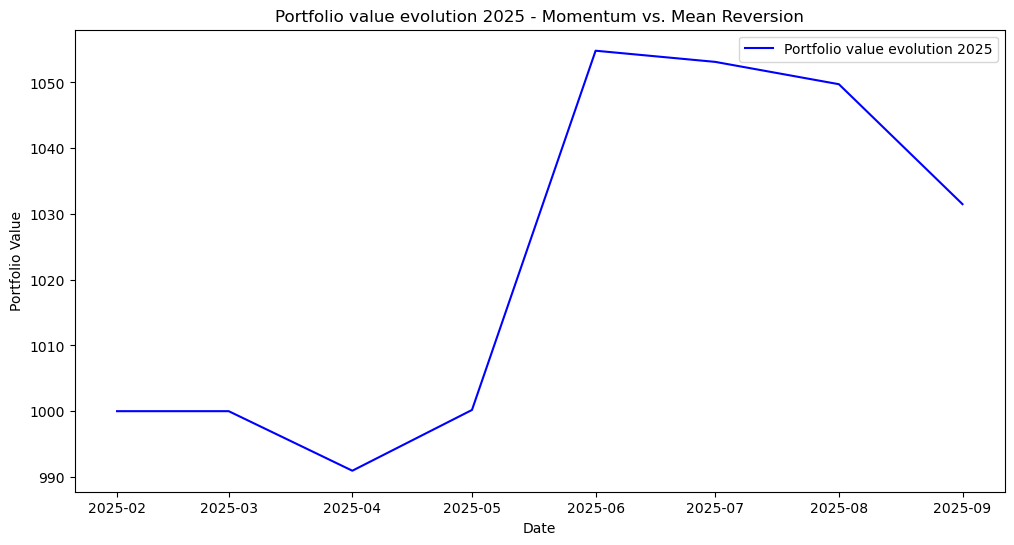

In [47]:
# plotting portfolio value over the next 7/8 months
plt.figure(figsize = (12, 6)) # size of the figure
plt.plot(forward_vix_slope['Period'], portfolio_value, label = 'Portfolio value evolution 2025', color = 'blue') 
plt.xlabel('Date') # setting label of x-axis
plt.ylabel('Portfolio Value') # setting label of y-axis
plt.title('Portfolio value evolution 2025 - Momentum vs. Mean Reversion') # title of the plot
plt.legend() # adding the legend
plt.show()

This means that if we apply those switches and the prices of SPY will be ones used for this analysis, we might end up having a 30% return on our portfolio (made of only SPY) for the next 7 months.

Below we propose a plot to visually check when the switches between momentum and mean reversion strategies would occur over the next months of 2025:

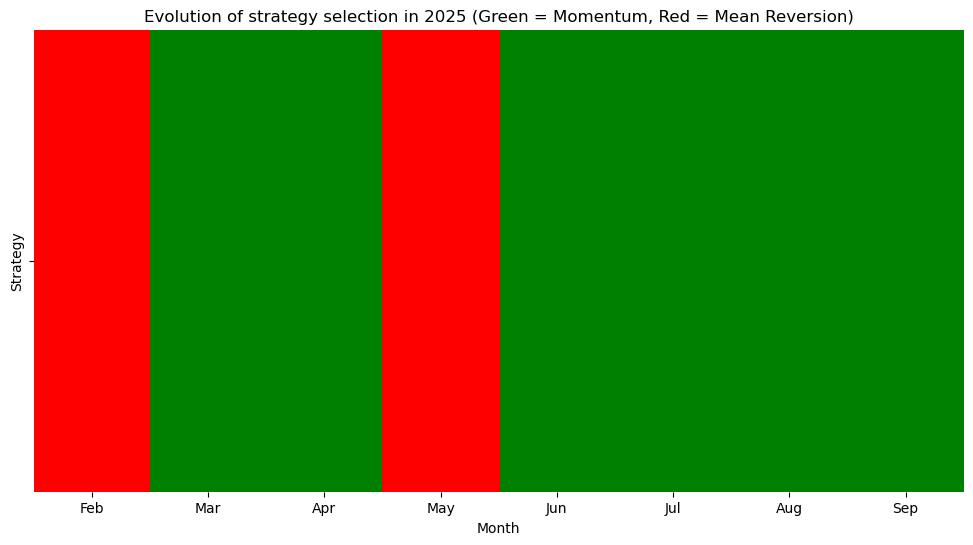

In [48]:
plt.figure(figsize = (12, 6)) # plotting the table with strategy selection
sns.heatmap(pd.DataFrame(strategy_type, index = spy_prices_pred_2025['Month'], columns = ['Strategy']).T == "Momentum", 
            cmap = ['red', 'green'], cbar = False) # we are displaying the Strategy column of strategy_type variable
plt.title("Evolution of strategy selection in 2025 (Green = Momentum, Red = Mean Reversion)") # title of the plot
plt.show()

In order to understand if this really makes sense, we ran the backtest also on past data.

In [49]:
## does this really make sense? Let'see a proper backtesting, meaning how it would have behaved in the past
transformer_data_hist = correlation_dataset # let's assign the historical dataset containing vix slope and spy returns to a new variable
transformer_data_hist = transformer_data_hist.join(spy_prices_hist, how = 'left') # adding the prices from SPY to the historical dataframe
transformer_data_hist.drop('SPY returns', axis = 1, inplace = True) # dropping the returns column as it is not needed now
correlation_dataset = correlation_dataset.join(spy_prices_hist, how = 'left') # adding the prices from SPY to the historical dataframe
correlation_dataset.drop('SPY returns', axis = 1, inplace = True) # we basically did the same for both these two variables, for ease of manipulation later
transformer_data_hist

,vix_slope,Adj Close
Period,,
2005-08-01,-0.012278,84.800415
2006-02-01,0.000806,89.558945
2006-03-01,0.021000,90.676437
2006-05-01,-0.014500,89.410240
2006-08-01,-0.014167,92.009865
...,...,...
2024-06-01,-0.013038,538.997009
2024-07-01,-0.012512,547.283691
2024-08-01,-0.011303,560.071289


As it was done previously for 2025 data, we need to adapt the input data to the framework used for training the momentum transformer model. Therefore, the input data must be re-shaped into a numpy array with 3 dimensions: the number of observations (in this case we have 166 monthly observations from 2007 to 2024), the length of the sequence of reading the data, the number of variables (VIX futures term structure slope and the SPY prices).

In [50]:
transformer_data_hist = np.array(transformer_data_hist) # turning the dataframe into a numpy array, as it is needed by the transformer model

# now the vix slope variable needs to be transformed into an array of shape similar to the one used for train
# therefore I am setting the final parameters I want:
num_obs = 166 # number of observations (because we have 166 observations from 2007 to 2024 for the historical VIX futures slope)
timesteps = 5 # sequence used to train the model
features = 2 # variables 

transformer_expanded_data_hist = np.zeros((num_obs, timesteps, features)) # storing memory for the expanded data

for i in range(num_obs): # expanding the data repeating values but making sure that each value appears at least once
    for t in range(timesteps):
        transformer_expanded_data_hist[i, t] = transformer_data_hist[(i + t) % num_obs]

initial_mom_prob_hist = transformer_model.predict(transformer_expanded_data_hist).flatten() # creating initial momentum probabilities using the trained transformer model

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


The functions to identify the momentum and mean reversion signals are, of course, the same ones that we used for 2025 data.

In [52]:
def momentum_signal(vix_slope): # defining a function for the momentum signal
    return np.sign(vix_slope)  # momentum signal is activated when VIX future slope is decreasing (contango steepening)

def mean_reversion_signal(stock_returns): # defining a function for the mean reversion signal
    return -np.sign(stock_returns)  # mean reversion signal is activated when returns are extreme

# generating trading signals
momentum_component_hist = initial_mom_prob_hist * momentum_signal(correlation_dataset['vix_slope']) # momentum signals are given by the momentum probabilities multiplied by whether the vix slope gives us momentum vibes
mean_reversion_component_hist = (1 - initial_mom_prob_hist) * mean_reversion_signal(correlation_dataset['Adj Close'].pct_change()) # mean reversion signals are given by the momentum probabilities multiplied by whether the returns give us mean reversion vibes
trading_signal_hist = momentum_component_hist + mean_reversion_component_hist # summing

strategy_type_hist = np.where(momentum_component_hist > mean_reversion_component_hist, "Momentum", "Mean Reversion") # showing the active strategy at each time step
strategy_type_hist

array(['Mean Reversion', 'Momentum', 'Momentum', 'Mean Reversion',
       'Momentum', 'Momentum', 'Momentum', 'Momentum', 'Momentum',
       'Mean Reversion', 'Mean Reversion', 'Momentum', 'Momentum',
       'Mean Reversion', 'Mean Reversion', 'Momentum', 'Momentum',
       'Mean Reversion', 'Mean Reversion', 'Momentum', 'Mean Reversion',
       'Momentum', 'Mean Reversion', 'Momentum', 'Momentum', 'Momentum',
       'Mean Reversion', 'Momentum', 'Momentum', 'Momentum',
       'Mean Reversion', 'Momentum', 'Momentum', 'Momentum', 'Momentum',
       'Mean Reversion', 'Mean Reversion', 'Momentum', 'Mean Reversion',
       'Momentum', 'Momentum', 'Mean Reversion', 'Momentum',
       'Mean Reversion', 'Mean Reversion', 'Mean Reversion',
       'Mean Reversion', 'Mean Reversion', 'Momentum', 'Momentum',
       'Mean Reversion', 'Mean Reversion', 'Momentum', 'Momentum',
       'Momentum', 'Momentum', 'Mean Reversion', 'Momentum', 'Momentum',
       'Momentum', 'Momentum', 'Mean Reversion', '

From the results above, we can observe that switches for the last 17 years occur quite often. It will become more clear and it will be easier to comment on it by visualizing below later.

The same backtesting function previously defined is run now for past data:

In [53]:
def backtest_trading_signals_hist(signals, stock_prices, initial_capital = 1000): # function for an initial backtest with a simulated initial capital of 1,000 euro
    monthly_returns = stock_prices.pct_change().fillna(0) # monthly returns are calculated as percentage difference
    strategy_returns = signals.shift(1).fillna(0) * monthly_returns  # shift to avoid lookahead bias
    cumulative_returns = (1 + strategy_returns).cumprod() # cumulative multiplication of returns
    portfolio_value = initial_capital * cumulative_returns  # portfolio evolution over time
    return portfolio_value, strategy_returns

# running backtest on the trading signal previously generated and the SPY historical prices
portfolio_value_hist, strategy_returns_hist = backtest_trading_signals(pd.Series(trading_signal_hist, index = correlation_dataset.index), 
                                                              correlation_dataset['Adj Close'])

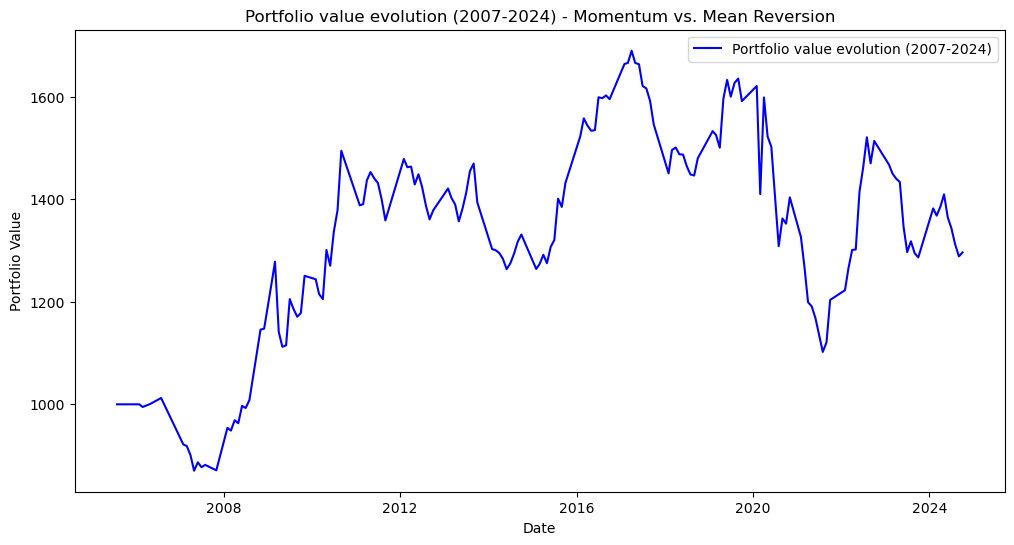

In [54]:
correlation_dataset.reset_index(drop = False, inplace = True) # separating the dates column as they are needed for the plot

# plotting potential historical portfolio value over the last 17 years
plt.figure(figsize = (12, 6)) # size of the figure
plt.plot(correlation_dataset['Period'], portfolio_value_hist, label = 'Portfolio value evolution (2007-2024)', color = 'blue') 
plt.xlabel('Date') # setting label of x-axis
plt.ylabel('Portfolio Value') # setting label of y-axis
plt.title('Portfolio value evolution (2007-2024) - Momentum vs. Mean Reversion') # title of the plot
plt.legend() # adding the legend
plt.show()

If we used our momentum transformer model to decide whether to use momentum or mean reversion in each specific month between 2007 and 2024, we would have ended up with a 300% return in 17 years, as we started from 1,000 Euro as initial capital and the final value on the plot seems to be at around 1,300. To put this into perspective, with a 1 Million Euro capital we would have had a 300,000 Euro return, which is not that bad for a one stock portfolio.

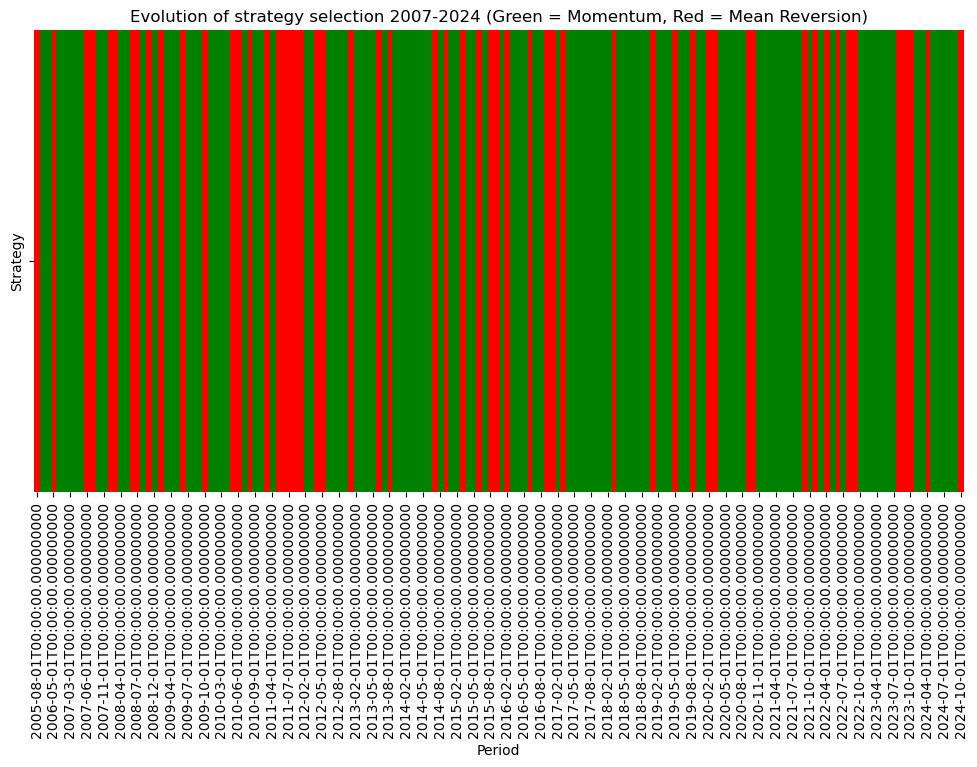

In [55]:
plt.figure(figsize = (12, 6)) # plotting the table with strategy selection
sns.heatmap(pd.DataFrame(strategy_type_hist, index = correlation_dataset['Period'], columns = ['Strategy']).T == "Momentum", 
            cmap = ['red', 'green'], cbar = False) # we are displaying the Strategy column of strategy_type variable
plt.title("Evolution of strategy selection 2007-2024 (Green = Momentum, Red = Mean Reversion)") # title of the plot
plt.show()

Finally, above we propose the visualization of the switches between momentum and mean reversion strategies from 2007 to 2024. The basic idea is that we should see momentum strategies suggested in periods of calm markets, while mean reversion should be preferred in periods of extreme movements. As a matter of fact, the model proposes to use mean reversion for the year 2011, which was characterised by a strong financial crisis in Europe, which evidently impacted the US stock market as well. We observe mean reversion adviced also from July 2021 to August 2022, which makes sense as the world was trying to recover from Covid crisis and then the Russia-Ukraine conflict occurred, which generated extreme movements in the equity markets.

# **Step 4: Innovative double-check and Backtesting**

Here the innovative part of our research starts: we are going to check and, eventually, confirm the switches between momentum and mean reversion produced by the momentum transformer model. First we take back the correlation_dataset, which contains past data of both SPY prices and VIX term structure slope, and we store it in a new variable of ease of interpretation, in addition to grouping 2025 data into a new dataframe.

In [56]:
correlation_dataset = constant_maturity_hist.join(spy_rets_hist, how = 'left') # retrieving initial dataframe
correlation_dataset = correlation_dataset.drop(['Tenor', 'Ticker', 'Last Price', 'Days past', 'Constant Maturity Price'], axis = 1) # dropping unnecessary columns for correlation analysis
correlation_dataset = correlation_dataset.dropna() # dropping the first NAs due to rolling window

In [57]:
historical_df = correlation_dataset # storing historical data of vix slope and spy returns in a new dataframe only for ease of understanding with names of the variables
df_2025 = pd.DataFrame({ # grouping the 2025 vix slope and spy rets data together, as before
    '2025 VIX futures slope': forward_vix_slope['vix_slope'],
    '2025 SPY prices': spy_prices_pred_2025['Close']
}).dropna() # dropping NAs

The idea is to use the same logic of the initially defined functions and to use rolling standard deviation, rolling correlation and rate of change as the three financial indicators to inquire on the switches between strategies. As it can be observed in the cell below, we decided to roll the indicators with an Exponentially Weighted Moving Average (EWMA), to give more relevance to more recent observations (the volatility of recent years could be more important than the volatility in 2007-2008 in order to understand what can happen over the next months).
We decided to use the average of the rolling volatility to assess whether we have high or low volatility.

In [58]:
## following the same reasoning of the 3 functions initially created, we decided to 
## compute rolling indicators but using an Exponentially Weighted Moving Average (EWMA),
## in order to give more relevance to recent observations (volatility of 2024 is much more relevant than 2007 for predicting 2025)
rolling_window = 5  # the idea is to reproduce initial functions with 5-day rolling window but with more weight on recent data

vol_indicator_hist = historical_df['SPY returns'].ewm(span = rolling_window).std() # calculating historical rolling volatility indicator on the historical returns of SPY
vol_indicator_2025 = df_2025['2025 SPY prices'].pct_change().ewm(span = rolling_window).std() # calculating rolling volatility indicator on the 2025 returns of SPY

# the same for rolling correlation
correlation_indicator_hist = historical_df['SPY returns'].ewm(span = rolling_window).corr(historical_df['vix_slope'])
correlation_indicator_2025 = df_2025['2025 SPY prices'].pct_change().ewm(span = rolling_window).corr(df_2025['2025 VIX futures slope'])

roc_indicator_hist = historical_df['vix_slope'].diff() # for the moment, we considered here to calculate rate of change (ROC) of VIX slope as absolute difference to avoid having inf and nan
roc_indicator_2025 = df_2025['2025 VIX futures slope'].diff() # rate of change for 2025 vix slope

volatility_mean = vol_indicator_hist.mean() # setting volatility threshold to assess if we should apply momentum or mean reversion
volatility_mean

0.04069298822209211

Calculations above show that, over the last 17 years, SPY prices had a 4% overall volatility.

Here the main innovative part comes: momentum and mean reversion strategies will be confirmed based on the three financial indicators.
As momentum should be preferred in contango, we defined a lower than average volatility as a momentum signal. This can be eventually reinforced by correlation higher than or equal to 0.3 (if vix slope and SPY prices move similarly, momentum is expected to stay) and a negative rate of change of the VIX term structure slope (decreasing term structure slope means increasing prices of VIX futures, therefore contango).
The opposite will be true for mean reversion, and hold is chosen as a strategy when the situation is unclear.

In [60]:
## the idea now is to, somehow, confirm the strategies outputted by the momentum transformer model, using the three indicators
def confirmation_transformer_strategy(returns, vix_slope, vol, corr, roc): # the function will take stock returns, VIX futures term structure slope and the 3 indicators as inputs
    momentum_strong = (vol < volatility_mean) # if volatility now is low, it means we are in contango and momentum strategy should be preferred
    momentum_confirmed = (momentum_strong & (corr >= 0.3)) | (momentum_strong & (roc < 0)) # after looking at volatility, another check can come from correlation and rate of change
    
    mean_reversion_strong = (vol > volatility_mean) # if volatility now is high, it means we are in backwardation, returns are extreme and mean reversion strategy should be preferred
    mean_reversion_confirmed = (mean_reversion_strong & (corr < 0.3)) | (mean_reversion_strong & (roc > 0)) # after looking at volatility, another check can come from correlation and rate of change

    strategy = np.where(momentum_confirmed, 'Momentum', # associating a strategy to each month based on the previously defined conditions based on conditions
                np.where(mean_reversion_confirmed, 'Mean Reversion', 'Hold'))  # if nothing happens, let's go for hold
    
    return strategy

strategy_2025 = confirmation_transformer_strategy( # running the strategy confirmation function on 2025 data
    df_2025['2025 SPY prices'], df_2025['2025 VIX futures slope'], vol_indicator_2025, correlation_indicator_2025, roc_indicator_2025)

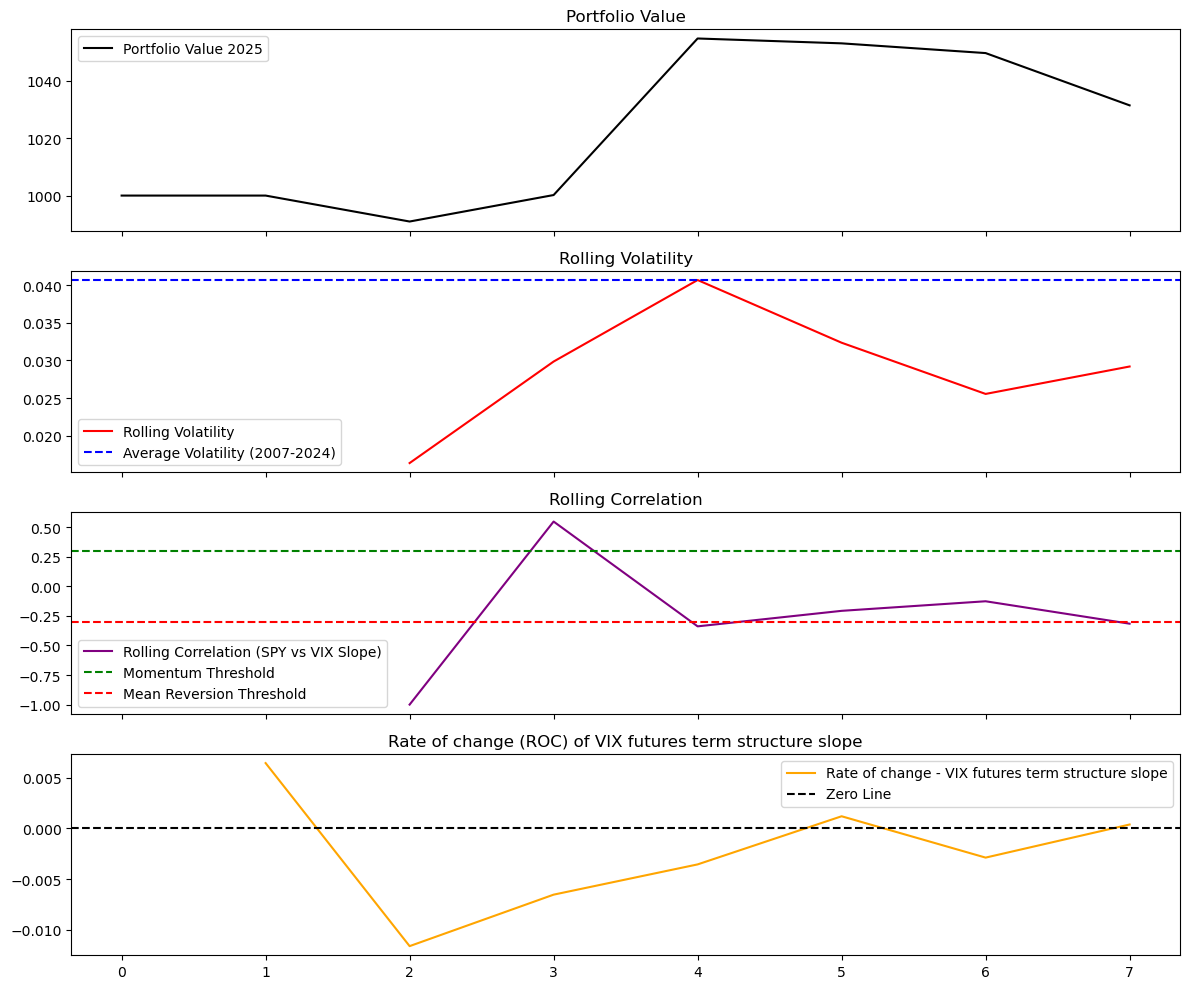

In [61]:
# displaying the results
fig, ax = plt.subplots(4, 1, figsize = (12, 10), sharex = True) # dividing the whole plot into 4 subplots
ax[0].plot(df_2025.index, portfolio_value, label = 'Portfolio Value 2025', color = 'black') # showing portfolio value obtained in previous part of the code
ax[0].set_title('Portfolio Value') # title of first subplot
ax[0].legend() # displaying elgend

ax[1].plot(df_2025.index, vol_indicator_2025, label = 'Rolling Volatility', color = 'red') # showing rolling volatility of 2025 SPY returns
ax[1].axhline(volatility_mean, linestyle = '--', color = 'blue', label = 'Average Volatility (2007-2024)') # plotting also the volatility threshold
ax[1].set_title('Rolling Volatility') # title of the second subplot
ax[1].legend() # displaying legend

ax[2].plot(df_2025.index, correlation_indicator_2025, label = 'Rolling Correlation (SPY vs VIX Slope)', color = 'purple') # showing rolling correlation between SPY and VIX futures term structure slope
ax[2].axhline(0.3, linestyle = '--', color = 'green', label = 'Momentum Threshold') # contextualizing correlation with the momentum threshold applied
ax[2].axhline(-0.3, linestyle = '--', color = 'red', label = 'Mean Reversion Threshold') # contextualizing correlation with the mean reversion threshold applied
ax[2].set_title('Rolling Correlation') # title of third subplot
ax[2].legend() # displaying legend

ax[3].plot(df_2025.index, roc_indicator_2025, label = 'Rate of change - VIX futures term structure slope', color = 'orange') # showing ROC of VIX slope
ax[3].axhline(0, linestyle = '--', color = 'black', label = 'Zero Line') # 0 is the threhsold selected
ax[3].set_title('Rate of change (ROC) of VIX futures term structure slope') # title of the fourth subplot
ax[3].legend() # displaying legend

plt.tight_layout() # visual setting
plt.show()

Above, we plotted the portfolio value already shown earlier, together with the rolling volatility, rolling correlation and rate of change. 
The rolling volatility is below the historical average for all next months, therefore suggesting a lower volatility today that will be followed by gradually higher volatility in the future: this suggests the presence of a contango environment.
Rolling correlation somehow slightly diverges in terms of momentum and mean reversion signals, as it is only for one month above the momentum threshold, then in a kind of hold situation and only at the very beginning in place for alerting a mean reversion preferral.
The rate of change seems to be mainly negative, which would suggest a contango environment. The positive rate of change at the 5th observation period is confirmed by the choice of mean reversion, suggested by the model, between April and May.

In [62]:
volatility_threshold = volatility_mean # defining volatility threshold
correlation_threshold_low = 0.3 # defining no correlation threshold (everything below 0.3 will be considered as not high enough correlation)
correlation_threshold_high = 0.3 # defining correlation threshold (everything above 0.3 will be considered high enough correlation)

confirmation_check = [] # pre-allocating memory for the checks to confirm the strategies or eventually modify them
for i in range(len(vol_indicator_2025)):
    if vol_indicator_2025[i] < volatility_threshold: # lower than average volatility is considered as momentum signal
        vol_signal = "Momentum"
    else:
        vol_signal = "Mean Reversion"
    
    if correlation_indicator_2025[i] >= correlation_threshold_low: # higher than 0.3 correlation is considered as momentum signal
        corr_signal = "Momentum"
    elif correlation_indicator_2025[i] < correlation_threshold_high: # lower than 0.3 correlation is considered as mean reversion signal
        corr_signal = "Mean Reversion"
    else:
        corr_signal = None  # allowing for a neutral case
    
    if roc_indicator_2025[i] < 0: # a negative rate of change in the vix slope is associated to contango, therefore momentum signal
        roc_signal = "Momentum"
    else:
        roc_signal = "Mean Reversion"
    
    signals = [vol_signal, corr_signal, roc_signal] # listing the signals coming from the three indicators
    signals = [s for s in signals if s is not None]  # removing neutral cases
    
    if signals.count("Momentum") > signals.count("Mean Reversion"): # the confirmed strategy will simply be the one which has the majority of "votes"
        confirmation_check.append("Momentum")
    else:
        confirmation_check.append("Mean Reversion")

confirmation_check = pd.Series(confirmation_check, index = forward_vix_slope['Period']) # converting the results to a dataframe for ease of manipulation
confirmation_check

Period
2025-02-01    Mean Reversion
2025-03-01    Mean Reversion
2025-04-01          Momentum
2025-05-01          Momentum
2025-06-01          Momentum
2025-07-01    Mean Reversion
2025-08-01          Momentum
2025-09-01    Mean Reversion
dtype: object

Above we show the strategies suggested by the checks performed on the financial indicators.

In [63]:
strategy_comparison = pd.DataFrame(strategy_type, index = forward_vix_slope['Period'], columns = ['Strategy']) # comparing checks with initial strategy identification
strategy_comparison['Confirmation/Double-check'] = confirmation_check # appending the new strategy selections for comparison
strategy_comparison

,Strategy,Confirmation/Double-check
Period,,
2025-02-01,Mean Reversion,Mean Reversion
2025-03-01,Momentum,Mean Reversion
2025-04-01,Momentum,Momentum
2025-05-01,Mean Reversion,Momentum
2025-06-01,Momentum,Momentum
2025-07-01,Momentum,Mean Reversion
2025-08-01,Momentum,Momentum
2025-09-01,Momentum,Mean Reversion


The comparison shows that the checks performed with the three financial indicators are better at agreeing with momentum signal than mean reversion strategies. This might probably be due to how we developed the confirmation_transformer_strategy function: these attribution of signals to momentum and mean reversion might be too strict and less dynamic (adaptable) leading to choices that might be better shaped. This is a scope of improvement of this approach.

Next, we define a function to combine the signals produced by the momentum transformer with the signals suggested by the financial indicators approach.

In [64]:
def dual_strategy_identification(transformer_signal, vol, corr, roc): # finally defining a function to enhance strategy decision-making process by combining transformer with indicators
    
    momentum_strong = vol < volatility_mean # low volatility is a momentum signal
    mean_reversion_strong = vol > volatility_mean # high volatility is a mean reversion signal
    
    momentum_confirmed = momentum_strong & ((corr >= 0.3) | (roc < 0)) # momentum is eventually confirmed if high correlation and negative rate of change
    mean_reversion_confirmed = mean_reversion_strong & ((corr < 0.3) | (roc > 0)) # mean reversion is eventually confirmed if low correlation and positive rate of change

    strategy = np.where(momentum_confirmed, 'Momentum',
                np.where(mean_reversion_confirmed, 'Mean Reversion', transformer_signal))  # by default, the strategy will be picked among momentum transformer results
    
    return strategy

In [65]:
def performance_assessment(cumulative_returns): # defining a function for displaying key characteristics of the strategy performance
    total_return = cumulative_returns.iloc[-1] - 1 # computing total returns
    annualized_return = (1 + total_return) ** (1 / (len(cumulative_returns) / 252)) - 1 # computing annualized returns
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min() # retrieving maximum drawdown
    
    print(f"Total return: {total_return:.2%}") # printing total returns
    print(f"Annualized return: {annualized_return:.2%}") # printing annualized returns
    print(f"Maximum drawdown: {max_drawdown:.2%}") # printing maximum drawdown

final_strategy = dual_strategy_identification(strategy_comparison['Strategy'], vol_indicator_2025, correlation_indicator_2025, roc_indicator_2025) # running the double strategy function on 2025 data
final_strategy

array(['Mean Reversion', 'Momentum', 'Momentum', 'Momentum', 'Momentum',
       'Momentum', 'Momentum', 'Momentum'], dtype=object)

Leaving aside the first month where mean reversion is suggested, the combined strategy suggests to mainly go for momentum and this is understandable, if one looks at the VIX futures term structure for 2025: the slope is decreasing, meaning that futures prices are trading at a premium with respect to spot price, which suggests low volatility today and the preferral for momentum strategy.

In [66]:
def compute_portfolio_returns(strategy, returns): # defining a function that will calculate returns based on the strategy identified and selected
    """
    If 'Momentum', we assume we follow the market return, while with 
    'Mean Reversion' we assume we take the opposite sign of returns.
    """
    portfolio_returns = np.where(strategy == 'Momentum', returns, -returns)
    return pd.Series(portfolio_returns, index=returns.index)

final_portfolio_returns = compute_portfolio_returns(final_strategy, df_2025['2025 SPY prices'].pct_change()) # calculating portfolio returns based on the final strategy

final_cumulative_returns = (1 + final_portfolio_returns).cumprod() # computing final cumulative returns

print("Final Strategy Performance:")
performance_assessment(final_cumulative_returns) # assessing dual strategy performance

Final Strategy Performance:
Total return: 12.60%
Annualized return: 4106.32%
Maximum drawdown: -2.74%


After computing cumulative returns and running the performance evaluation function, we obtain a 12.6% total return with a maximum drawdown of -2.74%. These numbers are pretty good, even if one pitfall of this analysis is the limited data availability, as 7/8 months is definitely not enough to be sure that this is what we are actually going to get with the combination of the two strategies. However, it seems to work fine.

Next, we compare the cumulative returns of the combined strategy together with cumulative returns we would get using only the momentum transformer switches.

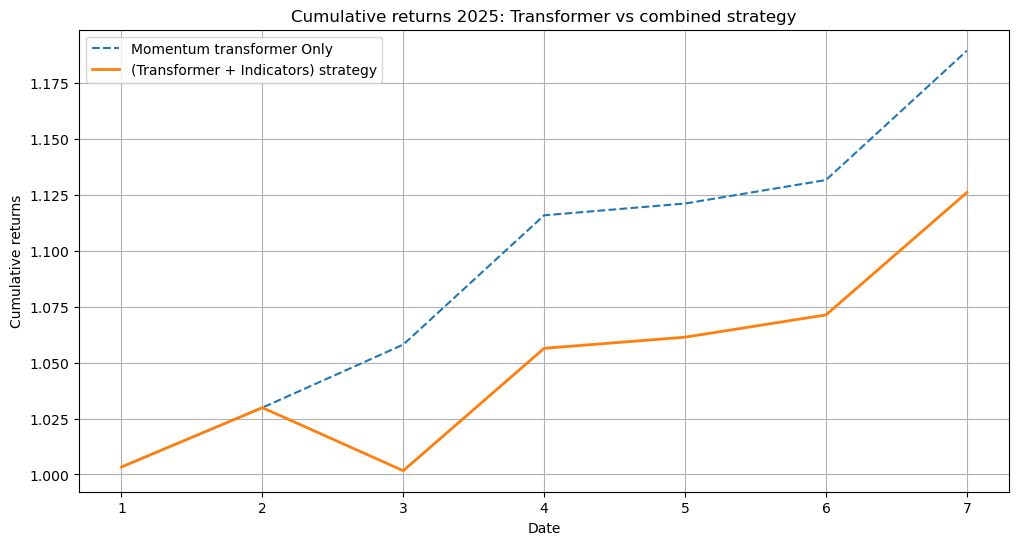

In [67]:
plt.figure(figsize = (12, 6)) # plotting the momentum transformer strategy together with the dual strategy
plt.plot((1 + compute_portfolio_returns(strategy_comparison['Strategy'], df_2025['2025 SPY prices'].pct_change())).cumprod(), label = "Momentum transformer Only", linestyle = 'dashed') # cumulative returns if using only momentum transformer
plt.plot(final_cumulative_returns, label = "(Transformer + Indicators) strategy", linewidth = 2) # cumulative returns if using combined strategy
plt.legend() # displaying legend
plt.title("Cumulative returns 2025: Transformer vs combined strategy") # title of the plot
plt.xlabel("Date") # x-axis are with dates
plt.ylabel("Cumulative returns") # cumulative returns on the y-axis
plt.grid()
plt.show()

The cumulative returns plot shows that the combined strategy would underperform the momentum transformer strategy. Nonetheless, the combined strategy still performs positively and forecasts a 12.6% return in 7/8 months, which is a pretty decent return. This suggests us that it is probably possible to improve this strategy, playing around with the thresholds of the three financial indicators.

In order to somehow validate what we observed for the future, we are going to show a proper backtesting, applying the same analysis on historical data.

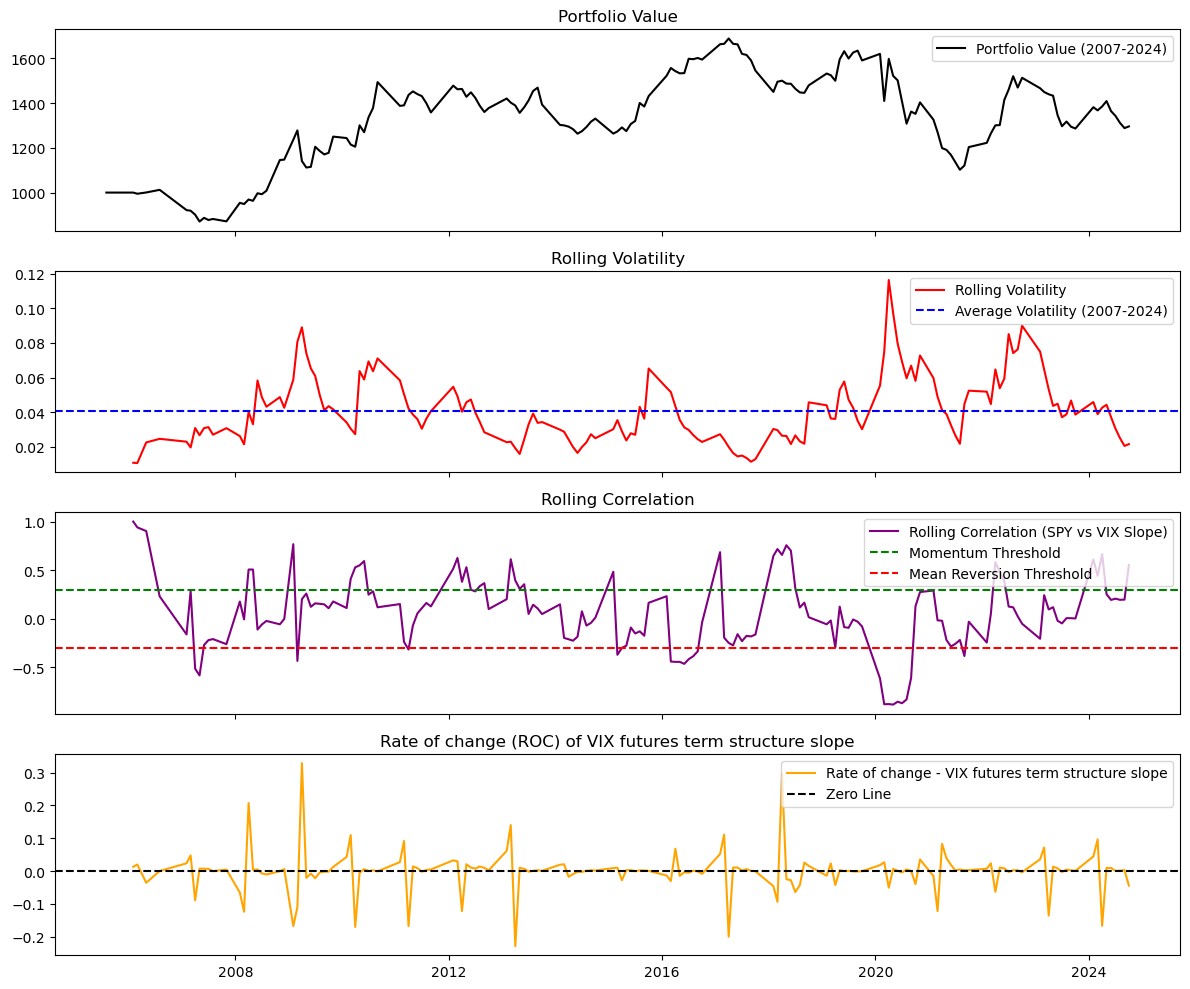

In [68]:
## what would have happened in the past?
correlation_dataset = correlation_dataset.join(spy_prices_hist, how = 'left') # adding back the historical prices of SPY

strategy_hist = confirmation_transformer_strategy( # running the strategy confirmation function on historical data
    correlation_dataset['Adj Close'], correlation_dataset['vix_slope'], vol_indicator_hist, correlation_indicator_hist, roc_indicator_hist)

# displaying the results
fig, ax = plt.subplots(4, 1, figsize = (12, 10), sharex = True) # dividing the whole plot into 4 subplots
ax[0].plot(correlation_dataset.index, portfolio_value_hist, label = 'Portfolio Value (2007-2024)', color = 'black') # showing portfolio value obtained in previous part of the code
ax[0].set_title('Portfolio Value') # title of first subplot
ax[0].legend() # displaying elgend

ax[1].plot(correlation_dataset.index, vol_indicator_hist, label = 'Rolling Volatility', color = 'red') # showing rolling volatility of historical SPY returns
ax[1].axhline(volatility_mean, linestyle = '--', color = 'blue', label = 'Average Volatility (2007-2024)') # plotting also the volatility threshold
ax[1].set_title('Rolling Volatility') # title of the second subplot
ax[1].legend() # displaying legend

ax[2].plot(correlation_dataset.index, correlation_indicator_hist, label = 'Rolling Correlation (SPY vs VIX Slope)', color = 'purple') # showing rolling correlation between SPY and VIX futures term structure slope
ax[2].axhline(0.3, linestyle = '--', color = 'green', label = 'Momentum Threshold') # contextualizing correlation with the momentum threshold applied
ax[2].axhline(-0.3, linestyle = '--', color = 'red', label = 'Mean Reversion Threshold') # contextualizing correlation with the mean reversion threshold applied
ax[2].set_title('Rolling Correlation') # title of third subplot
ax[2].legend() # displaying legend

ax[3].plot(correlation_dataset.index, roc_indicator_hist, label = 'Rate of change - VIX futures term structure slope', color = 'orange') # showing ROC of VIX slope
ax[3].axhline(0, linestyle = '--', color = 'black', label = 'Zero Line') # 0 is the threhsold selected
ax[3].set_title('Rate of change (ROC) of VIX futures term structure slope') # title of the fourth subplot
ax[3].legend() # displaying legend

plt.tight_layout() # visual setting
plt.show()

While the portfolio value plot for historical data was already generated earlier, now we can see a much more diversified behavior when it comes to rolling volatility, rolling correlation and rate of change, because all three financial indicators move above and below the respective thresholds. Among the interesting things to observe: positive spike in 2009 rate of change, clearly suggesting a mean reversion strategy due to subprime crisis (extreme movements should be followed by mean-reverting adjustments), extremely negative correlation between SPY prices and VIX futures term structure slope during Covid period (as well as high volatility), generally low volatility between 2012 and 2019, suggesting to follow the trend (momentum).

In [69]:
volatility_threshold = volatility_mean # defining volatility threshold
correlation_threshold_low = 0.3 # defining no correlation threshold (everything below 0.3 will be considered as not high enough correlation)
correlation_threshold_high = 0.3 # defining correlation threshold (everything above 0.3 will be considered high enough correlation)

confirmation_check_hist = [] # pre-allocating memory for the checks to confirm the strategies or eventually modify them
for i in range(len(vol_indicator_hist)):
    if vol_indicator_hist[i] < volatility_threshold: # lower than average volatility is considered as momentum signal
        vol_signal = "Momentum"
    else:
        vol_signal = "Mean Reversion"
    
    if correlation_indicator_hist[i] >= correlation_threshold_low: # higher than 0.3 correlation is considered as momentum signal
        corr_signal = "Momentum"
    elif correlation_indicator_hist[i] < correlation_threshold_high: # lower than 0.3 correlation is considered as mean reversion signal
        corr_signal = "Mean Reversion"
    else:
        corr_signal = None  # allowing for a neutral case
    
    if roc_indicator_hist[i] < 0: # a negative rate of change in the vix slope is associated to contango, therefore momentum signal
        roc_signal = "Momentum"
    else:
        roc_signal = "Mean Reversion"
    
    signals = [vol_signal, corr_signal, roc_signal] # listing the signals coming from the three indicators
    signals = [s for s in signals if s is not None]  # removing neutral cases
    
    if signals.count("Momentum") > signals.count("Mean Reversion"): # the confirmed strategy will simply be the one which has the majority of "votes"
        confirmation_check_hist.append("Momentum")
    else:
        confirmation_check_hist.append("Mean Reversion")

confirmation_check_hist = pd.Series(confirmation_check_hist, index = correlation_dataset.index) # converting the results to a dataframe for ease of manipulation

strategy_comparison_hist = pd.DataFrame(strategy_type_hist, index = correlation_dataset.index, columns = ['Strategy']) # comparing checks with initial strategy identification
strategy_comparison_hist['Confirmation/Double-check'] = confirmation_check_hist # appending the new strategy selections for comparison
strategy_comparison_hist

C:\Users\aless\AppData\Local\Temp\ipykernel_3740\559952275.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if vol_indicator_hist[i] < volatility_threshold: # lower than average volatility is considered as momentum signal
C:\Users\aless\AppData\Local\Temp\ipykernel_3740\559952275.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if correlation_indicator_hist[i] >= correlation_threshold_low: # higher than 0.3 correlation is considered as momentum signal
C:\Users\aless\AppData\Local\Temp\ipykernel_3740\559952275.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

,Strategy,Confirmation/Double-check
Period,,
2005-08-01,Mean Reversion,Mean Reversion
2006-02-01,Momentum,Momentum
2006-03-01,Momentum,Momentum
2006-05-01,Mean Reversion,Momentum
2006-08-01,Momentum,Mean Reversion
...,...,...
2024-06-01,Momentum,Mean Reversion
2024-07-01,Momentum,Mean Reversion
2024-08-01,Momentum,Mean Reversion


The table above shows the first column with the switches proposed by the momentum transformer model, while the second column displays the switches according to the rolling volatility, rolling correlation and rate of change indicators, for historical data.

In [70]:
final_strategy_hist = dual_strategy_identification(strategy_comparison_hist['Strategy'], vol_indicator_hist, correlation_indicator_hist, roc_indicator_hist) # running the double strategy function on historical data

final_portfolio_returns_hist = compute_portfolio_returns(final_strategy_hist, correlation_dataset['Adj Close'].pct_change()) # calculating portfolio returns based on the final strategy

final_cumulative_returns_hist = (1 + final_portfolio_returns_hist).cumprod() # computing final cumulative returns

print("Final Strategy Performance:")
performance_assessment(final_cumulative_returns_hist) # assessing dual strategy performance

Final Strategy Performance:
Total return: 133.47%
Annualized return: 262.24%
Maximum drawdown: -51.29%


Combining the two strategies, from 2007 to 2024 we would have had a 133.47% total return with a maximum drawdown of -51.29%. Total return is much higher than the total return for the months of 2025, obviously, given the wider time horizon. As well, though, the maximum drawdown value is much higher, again because of the fact that the considered time interval is wider and comprehends at least 3 crises.

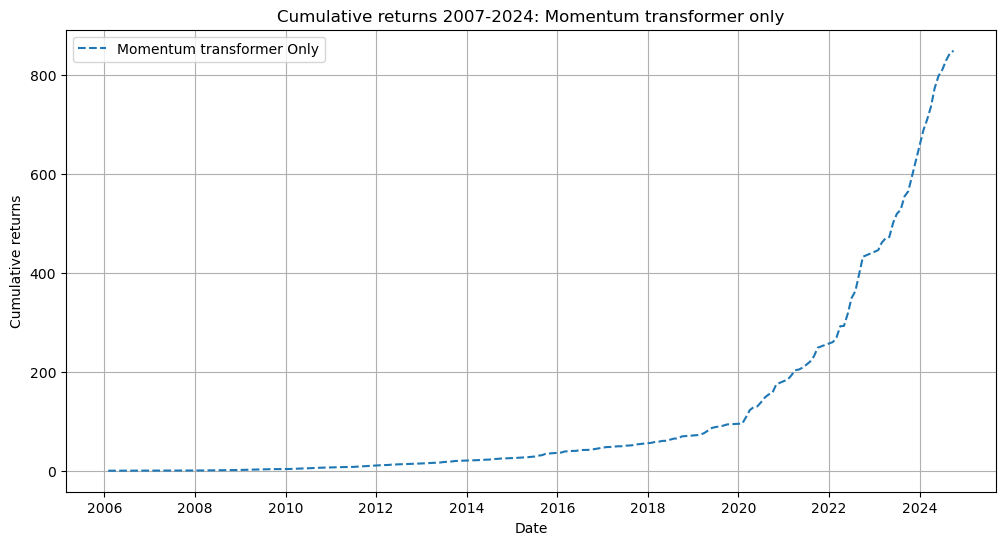

In [71]:
plt.figure(figsize = (12, 6)) # plotting the momentum transformer strategy only
plt.plot((1 + compute_portfolio_returns(strategy_comparison_hist['Strategy'], correlation_dataset['Adj Close'].pct_change())).cumprod(), label = "Momentum transformer Only", linestyle = 'dashed') # cumulative returns if using only momentum transformer
plt.legend() # displaying legend
plt.title("Cumulative returns 2007-2024: Momentum transformer only") # title of the plot
plt.xlabel("Date") # x-axis are with dates
plt.ylabel("Cumulative returns") # cumulative returns on the y-axis
plt.grid()
plt.show()

Applying the switches proposed only by the momentum transformer, we would have experienced an astonishing reward over the last 17 years, especially starting from Covid time.

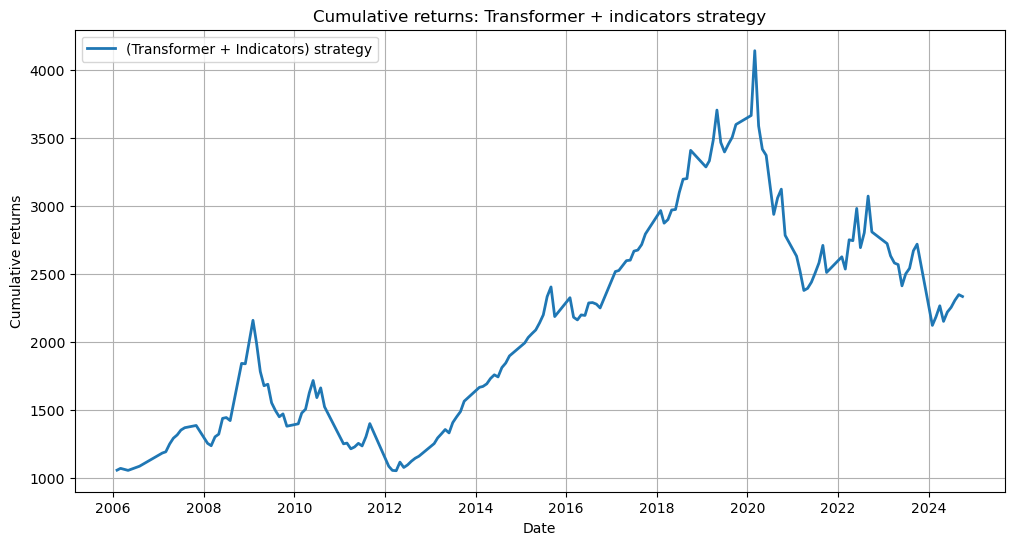

In [72]:
plt.figure(figsize = (12, 6)) # plotting the the dual strategy
plt.plot(final_cumulative_returns_hist * 1000, label = "(Transformer + Indicators) strategy", linewidth = 2) # cumulative returns if using combined strategy
plt.legend() # displaying legend
plt.title("Cumulative returns: Transformer + indicators strategy") # title of the plot
plt.xlabel("Date") # x-axis are with dates
plt.ylabel("Cumulative returns") # cumulative returns on the y-axis
plt.grid()
plt.show()

Combining the momentum transformer approach with the checks performed on financial indicators, the strategy would have performed greatly especially between 2012 and Covid time. However, starting from 2020, returns would have corrected significantly; nonetheless, the final value for returns is 133.47%. To put this into perspective, if you invested 1 million Euro at the beginning of 2006, this would have resulted in around 1,333,470 of gross profit only with this investment!